In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Conv1D, BatchNormalization, MaxPooling1D,
    GlobalMaxPooling1D, Dense, Dropout
)


2025-11-27 15:49:27.675194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("Loan_default.csv")
df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
df.isnull().sum()


LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

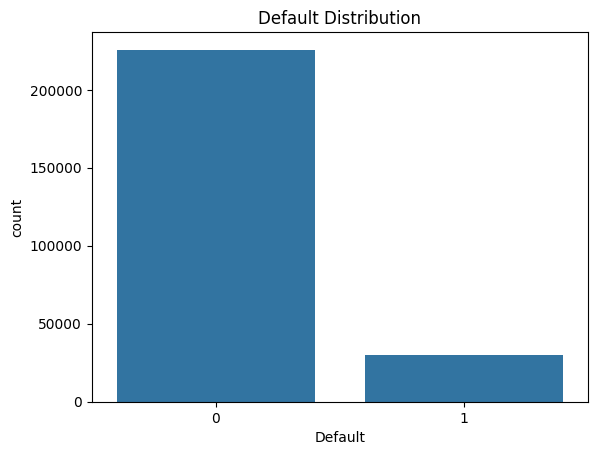

In [4]:
sns.countplot(data=df, x="Default")
plt.title("Default Distribution")
plt.show()


In [5]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols


Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default'],
      dtype='object')

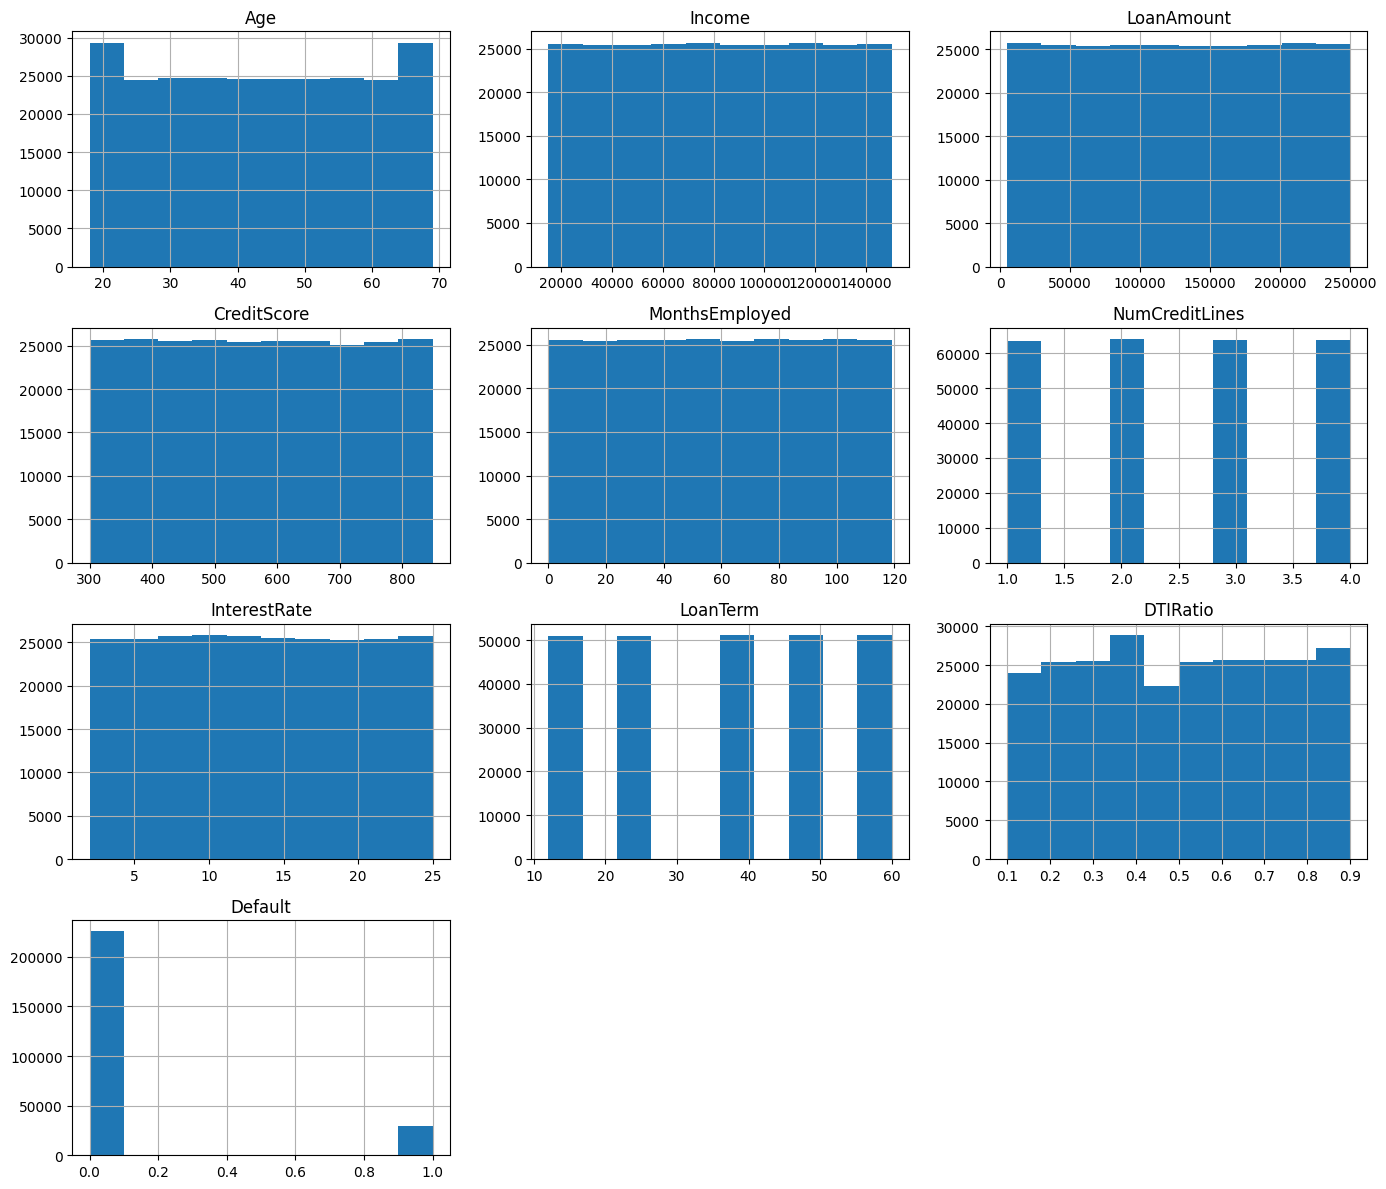

In [6]:
df[numeric_cols].hist(figsize=(14, 12))
plt.tight_layout()
plt.show()


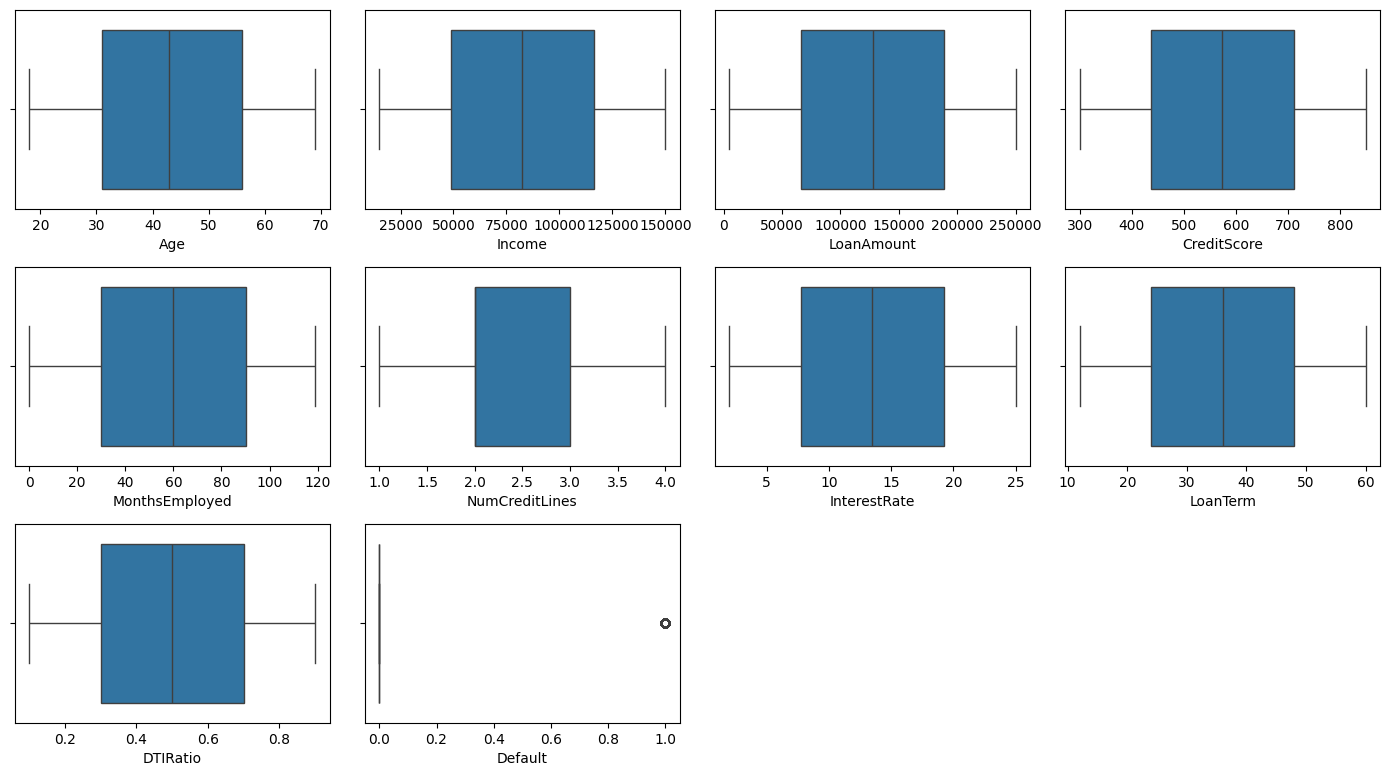

In [7]:
plt.figure(figsize=(14,10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=df[col])
plt.tight_layout()
plt.show()


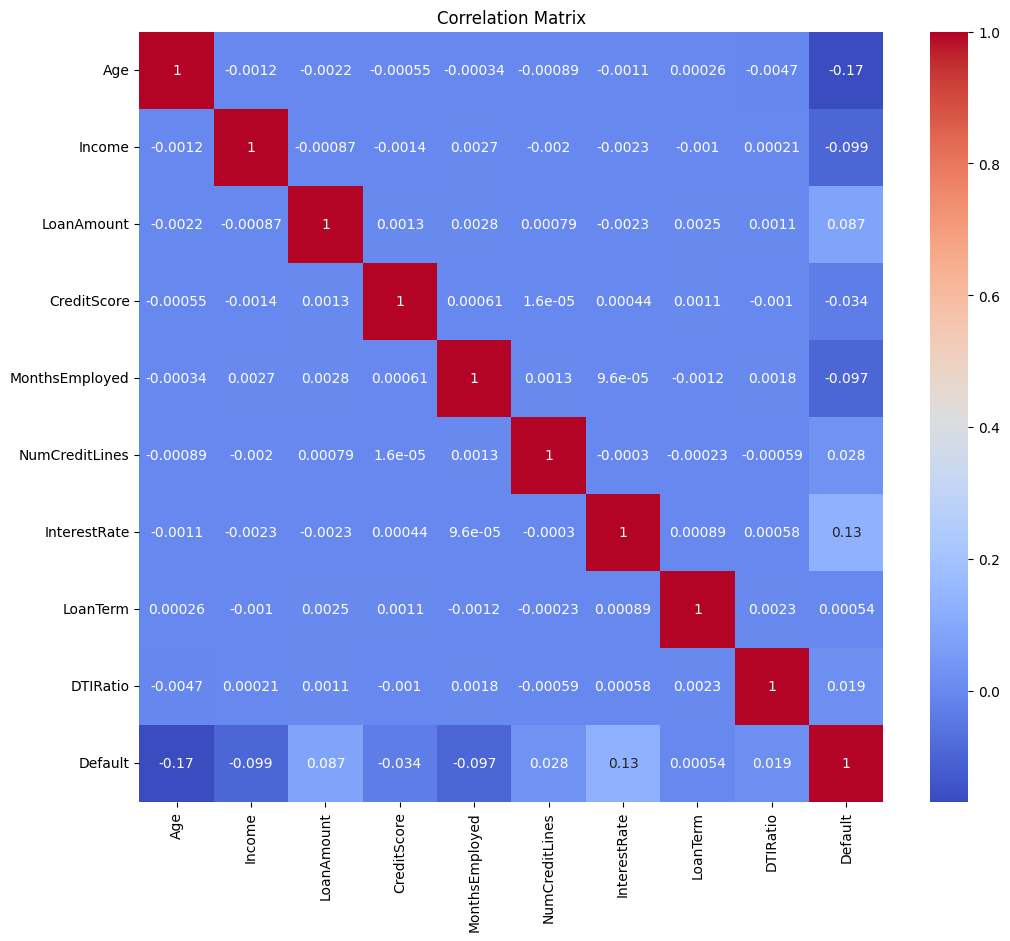

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols


Index(['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner'],
      dtype='object')

In [7]:
df_encoded = df.copy()
le = LabelEncoder()

for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])


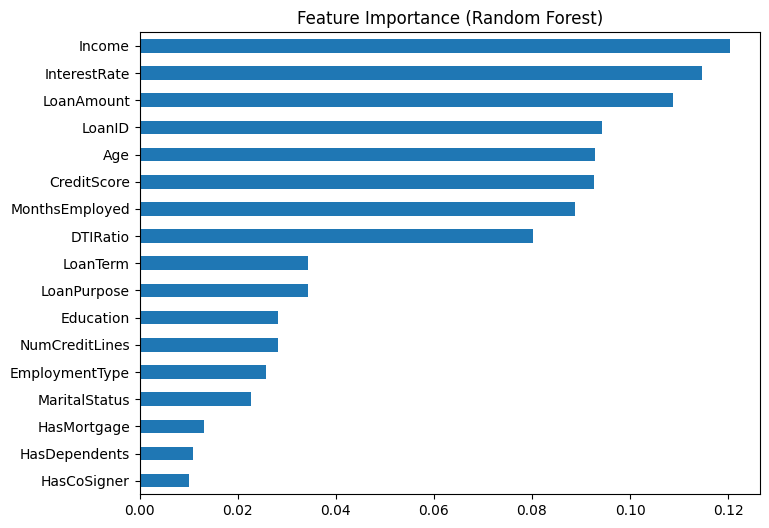

In [8]:
from sklearn.ensemble import RandomForestClassifier

X = df_encoded.drop("Default", axis=1)
y = df_encoded["Default"]

model = RandomForestClassifier()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (Random Forest)")
plt.show()


In [3]:
# Load dataset
df = pd.read_csv("Loan_default.csv")

# Features you want to keep
selected_features = [
    "Income",
    "InterestRate",
    "LoanAmount",
    "Age",
    "CreditScore",
    "MonthsEmployed",
    "DTIRatio"
]

X = df[selected_features]
y = df["Default"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
from sklearn.preprocessing import StandardScaler
import joblib

# Create scaler
scaler = StandardScaler()

# Fit on training data only
scaler.fit(X_train)

# Transform data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "loan_default_scaler.pkl")
print("Scaler saved as loan_default_scaler.pkl")


Scaler saved as loan_default_scaler.pkl


In [6]:

X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

X_train_cnn.shape, X_test_cnn.shape


((204277, 7, 1), (51070, 7, 1))

In [7]:
def build_cnn_1d(input_shape, drop_rate=0.3):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    
    # First conv block with more filters
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(drop_rate))
    
    # Second conv block
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(drop_rate))
    
    # Third conv block
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(drop_rate))
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Use a lower learning rate for better convergence
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy', 
                          tf.keras.metrics.AUC(name='auc'),
                          tf.keras.metrics.Recall(name='recall')])
    return model

n_features = X_train.shape[1]
model = build_cnn_1d((n_features, 1))
model.summary()

/home/stonie/miniconda3/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1764247803.810792   74123 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 128)         │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,137 (2.18 MB)

 Trainable params: 569,089 (2.17 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [8]:
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    ),
    
    # Save the best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [9]:
history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=50,  
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


2025-11-27 15:50:11.825005: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fdcd8018720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 15:50:11.825024: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-27 15:50:11.907044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 15:50:12.339370: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-27 15:50:12.711167: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-27 15:50:12.711237: I e

  79/5107 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4171 - auc: 0.4566 - loss: 1.1057 - recall: 0.5397 

I0000 00:00:1764247818.702212   75646 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5087/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7972 - auc: 0.5969 - loss: 0.4862 - recall: 0.1612

2025-11-27 15:50:28.594434: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-27 15:50:29.216468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2660', 28 bytes spill stores, 28 bytes spill loads

2025-11-27 15:50:29.297920: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2660', 24 bytes spill stores, 24 bytes spill loads



5107/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - auc: 0.5970 - loss: 0.4859 - recall: 0.1610

2025-11-27 15:50:36.293139: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-27 15:50:37.043576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_191', 28 bytes spill stores, 28 bytes spill loads

2025-11-27 15:50:37.101733: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_191', 24 bytes spill stores, 24 bytes spill loads




Epoch 1: val_loss improved from None to 0.31819, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.8534 - auc: 0.6385 - loss: 0.4000 - recall: 0.0870 - val_accuracy: 0.8868 - val_auc: 0.7343 - val_loss: 0.3182 - val_recall: 0.0362 - learning_rate: 1.0000e-04
Epoch 2/50
5097/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - auc: 0.6927 - loss: 0.3420 - recall: 0.0361
Epoch 2: val_loss improved from 0.31819 to 0.31787, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8821 - auc: 0.6956 - loss: 0.3414 - recall: 0.0299 - val_accuracy: 0.8873 - val_auc: 0.7354 - val_loss: 0.3179 - val_recall: 0.0132 - learning_rate: 1.0000e-04
Epoch 3/50
5100/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - auc: 0.7047 - loss: 0.3350 - recall: 0.0197
Epoch 3: val_loss did not improve from 0.31787
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8830 - auc: 0.7073 - loss: 0.3342 - recall: 0.0210 - val_accuracy: 0.8872 - val_auc: 0.7368 - val_loss: 0.3179 - val_recall: 0.0550 - learning_rate: 1.0000e-04
Epoch 4/50
5087/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - auc: 0.7096 - loss: 0.3320 - recall: 0.0193
Epoch 4: val_loss improved from 0.31787 to 0.31780, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8832 - auc: 0.7126 - loss: 0.3311 - recall: 0.0180 - val_accuracy: 0.8864 - val_auc: 0.7382 - val_loss: 0.3178 - val_recall: 0.0762 - learning_rate: 1.0000e-04
Epoch 5/50
5091/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8832 - auc: 0.7147 - loss: 0.3295 - recall: 0.0154
Epoch 5: val_loss improved from 0.31780 to 0.31657, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8831 - auc: 0.7178 - loss: 0.3289 - recall: 0.0157 - val_accuracy: 0.8871 - val_auc: 0.7379 - val_loss: 0.3166 - val_recall: 0.0550 - learning_rate: 1.0000e-04
Epoch 6/50
5103/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8824 - auc: 0.7199 - loss: 0.3299 - recall: 0.0279
Epoch 6: val_loss did not improve from 0.31657
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8834 - auc: 0.7198 - loss: 0.3279 - recall: 0.0223 - val_accuracy: 0.8877 - val_auc: 0.7377 - val_loss: 0.3172 - val_recall: 0.0641 - learning_rate: 1.0000e-04
Epoch 7/50
5100/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8838 - auc: 0.7216 - loss: 0.3266 - recall: 0.0223
Epoch 7: val_loss did not improve from 0.31657
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8835 - auc: 0.7241 - loss: 0.3262 - recall: 0.0216 - val_accuracy: 0.8874 - val_auc: 0.7375 - val_loss: 0.3169 - val_recall: 0.0649 - learning_rate: 1.0000e-04
Epoch 8/50
509

5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8833 - auc: 0.7254 - loss: 0.3256 - recall: 0.0235 - val_accuracy: 0.8873 - val_auc: 0.7368 - val_loss: 0.3157 - val_recall: 0.0494 - learning_rate: 1.0000e-04
Epoch 9/50
5084/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8836 - auc: 0.7271 - loss: 0.3247 - recall: 0.0228
Epoch 9: val_loss improved from 0.31571 to 0.31512, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8837 - auc: 0.7259 - loss: 0.3253 - recall: 0.0274 - val_accuracy: 0.8872 - val_auc: 0.7406 - val_loss: 0.3151 - val_recall: 0.0652 - learning_rate: 1.0000e-04
Epoch 10/50
5104/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - auc: 0.7267 - loss: 0.3249 - recall: 0.0285
Epoch 10: val_loss did not improve from 0.31512
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8836 - auc: 0.7276 - loss: 0.3247 - recall: 0.0309 - val_accuracy: 0.8874 - val_auc: 0.7394 - val_loss: 0.3151 - val_recall: 0.0494 - learning_rate: 1.0000e-04
Epoch 11/50
5081/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8836 - auc: 0.7270 - loss: 0.3252 - recall: 0.0273
Epoch 11: val_loss improved from 0.31512 to 0.31481, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8834 - auc: 0.7291 - loss: 0.3243 - recall: 0.0254 - val_accuracy: 0.8876 - val_auc: 0.7398 - val_loss: 0.3148 - val_recall: 0.0328 - learning_rate: 1.0000e-04
Epoch 12/50
5095/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8825 - auc: 0.7302 - loss: 0.3261 - recall: 0.0299
Epoch 12: val_loss did not improve from 0.31481
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8837 - auc: 0.7310 - loss: 0.3235 - recall: 0.0279 - val_accuracy: 0.8877 - val_auc: 0.7386 - val_loss: 0.3153 - val_recall: 0.0548 - learning_rate: 1.0000e-04
Epoch 13/50
5102/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - auc: 0.7307 - loss: 0.3246 - recall: 0.0391
Epoch 13: val_loss improved from 0.31481 to 0.31430, saving model to best_model.h5


5107/5107 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8840 - auc: 0.7302 - loss: 0.3237 - recall: 0.0343 - val_accuracy: 0.8879 - val_auc: 0.7395 - val_loss: 0.3143 - val_recall: 0.0481 - learning_rate: 1.0000e-04
Epoch 14/50
5093/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - auc: 0.7290 - loss: 0.3247 - recall: 0.0356
Epoch 14: val_loss did not improve from 0.31430
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8839 - auc: 0.7306 - loss: 0.3233 - recall: 0.0355 - val_accuracy: 0.8874 - val_auc: 0.7386 - val_loss: 0.3160 - val_recall: 0.0837 - learning_rate: 1.0000e-04
Epoch 15/50
5080/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8848 - auc: 0.7342 - loss: 0.3211 - recall: 0.0417
Epoch 15: val_loss did not improve from 0.31430
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8840 - auc: 0.7331 - loss: 0.3225 - recall: 0.0403 - val_accuracy: 0.8877 - val_auc: 0.7397 - val_loss: 0.3157 - val_recall: 0.0511 - learning_rate: 1.0000e-04
Epoch 16/5

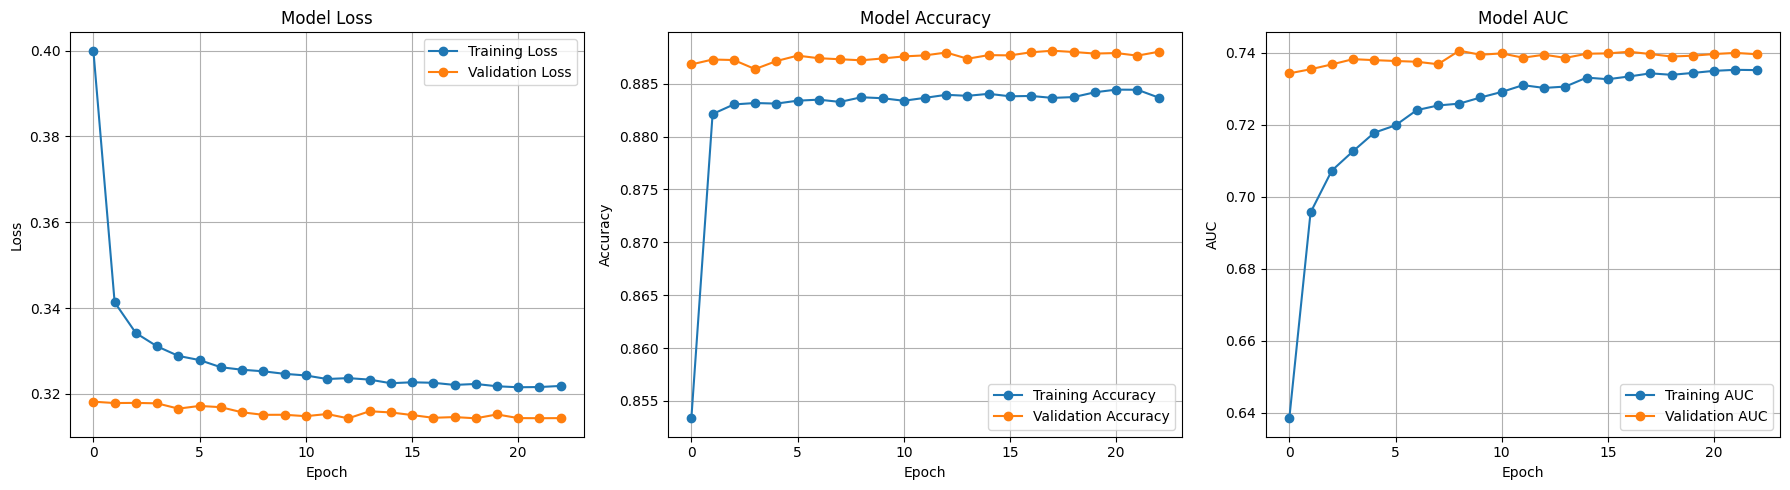

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='o')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# Check if AUC is available in history
if 'auc' in history.history:
    axes[2].plot(history.history['auc'], label='Training AUC', marker='o')
    axes[2].plot(history.history['val_auc'], label='Validation AUC', marker='o')
    axes[2].set_title('Model AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True)
else:
    # If no AUC, show learning rate or remove this subplot
    fig.delaxes(axes[2])

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# Calculate all metrics manually to be safe
y_pred_proba = model.predict(X_test_cnn).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print formatted results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

1535/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step

2025-11-27 15:57:28.187869: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-27 15:57:28.870090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_148', 28 bytes spill stores, 28 bytes spill loads

2025-11-27 15:57:28.892756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_148', 24 bytes spill stores, 24 bytes spill loads



1596/1596 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy: 0.8868
Precision: 0.6158
Recall: 0.0527
AUC: 0.7469


In [12]:
import pandas as pd

# Predict probabilities
y_pred_prob = model.predict(X_test_cnn).flatten()

# Mask for predicted default > 0.5
mask = y_pred_prob > 0.5

# Select corresponding rows from X_test
pred_default_cases = X_test[mask].copy()

# Add predicted probabilities and true labels
pred_default_cases["Pred_Prob"] = y_pred_prob[mask]
pred_default_cases["True_Default"] = y_test.values[mask]

pred_default_cases


1596/1596 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


,Income,InterestRate,LoanAmount,Age,CreditScore,MonthsEmployed,DTIRatio,Pred_Prob,True_Default
201544,21668,18.76,204640,42,718,5,0.32,0.505994,1
122127,20635,24.15,164819,35,352,21,0.11,0.539910,0
62043,76046,22.66,221956,22,392,18,0.47,0.503540,1
126246,19715,16.84,181897,41,528,6,0.61,0.514408,0
239298,28267,16.45,210383,22,318,71,0.42,0.510818,1
...,...,...,...,...,...,...,...,...,...
206534,25941,22.12,215606,25,365,13,0.73,0.700005,0
215228,16633,24.53,60485,18,480,11,0.56,0.568709,1
215245,40893,22.31,208861,32,607,18,0.70,0.500818,0
237971,29293,21.28,146224,18,501,7,0.28,0.578222,1


In [13]:
# Save the model in TensorFlow SavedModel format
model.save("cnn_loan_default_model.keras")
print("Model saved as 'cnn_loan_default_model/'")


Model saved as 'cnn_loan_default_model/'


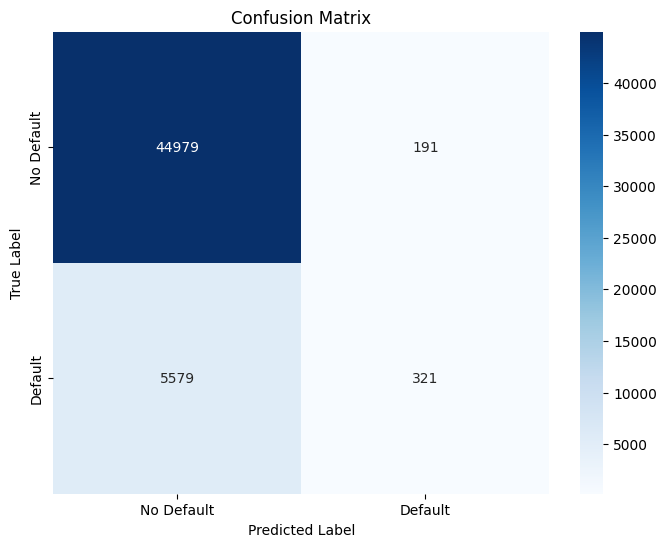

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Create confusion matrix with labels
cm = confusion_matrix(y_test, y_pred)
labels = ['No Default', 'Default']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()